In [0]:
!pip install pretrainedmodels

In [0]:
import torchvision
import pretrainedmodels

from fastai import *
from fastai.vision import *

In [0]:
def set_seed(seed=42):
    # python RNG
    import random
    random.seed(seed)

    # pytorch RNGs
    import torch
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    import numpy as np
    np.random.seed(seed)
    
set_seed()

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [0]:
def write_submission(preds, filename):
    sub = pd.read_csv('data/sample_submission_ns2btKE.csv')
    sub.category = preds
    sub.to_csv(filename, index=False)

In [0]:
def se_resnext50_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

In [0]:
np.random.seed(42)
src = (ImageList.from_csv('data', 'train.csv', folder='images')
       .split_by_rand_pct(0.2, seed=42)
       .label_from_df(cols='category')
       .add_test(ImageList.from_csv('data/', csv_name='test_ApKoW4T.csv', folder='images'))
      )

In [0]:
f_score = FBeta(average='weighted', beta=1)

## Size 128

In [0]:
tfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0., xtra_tfms=[rand_crop(), rand_zoom(1, 1.5), symmetric_warp(magnitude=(-0.2, 0.2))])

In [0]:
data = (src.transform(tfms, size=128, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=128).normalize(imagenet_stats))

In [0]:
learn = cnn_learner(data, se_resnext50_32x4d, pretrained=True, cut=-2,
                    split_on=lambda m: (m[0][3], m[1]), 
                    metrics=[error_rate, f_score])

In [0]:
learn.loss_func = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03


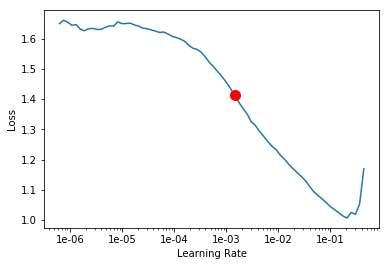

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(32, max_lr=slice(2e-2), wd=1e-5)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.783686,0.521885,0.312000,0.687195,00:25
1,0.576320,0.371548,0.288800,0.711119,00:23
2,0.445988,0.327498,0.282400,0.715822,00:23
3,0.377658,0.301254,0.254400,0.743485,00:23
4,0.344383,0.304360,0.260000,0.741288,00:23
5,0.316460,0.305449,0.244800,0.752542,00:23
6,0.302401,0.263586,0.209600,0.789321,00:23
7,0.274562,0.252272,0.212000,0.790174,00:23
8,0.248262,0.236926,0.207200,0.794623,00:23
9,0.223508,0.219241,0.184000,0.818284,00:23


In [0]:
learn.save('SE_ResNext50_FL_883903')

In [0]:
learn.unfreeze()
learn.clip_grad();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05


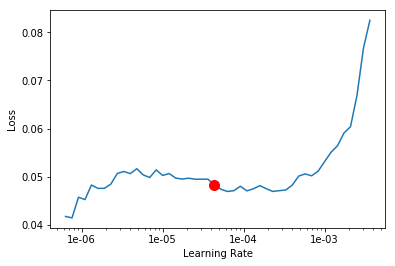

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.load('SE_ResNext50_FL_883903');
learn.unfreeze();
learn.clip_grad();

In [0]:
lr = [3e-3/100, 3e-3/20, 3e-3/10]

In [0]:
learn.fit_one_cycle(36, lr, wd=1e-7)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.043736,0.138167,0.119200,0.880815,00:31
1,0.038968,0.133116,0.113600,0.886770,00:31
2,0.037026,0.132410,0.109600,0.890209,00:31
3,0.034266,0.129377,0.105600,0.894221,00:31
4,0.028375,0.115355,0.098400,0.901829,00:31
5,0.028240,0.116211,0.092000,0.907974,00:31
6,0.025761,0.107698,0.089600,0.910440,00:31
7,0.024445,0.105821,0.089600,0.910551,00:31
8,0.022643,0.111722,0.081600,0.918585,00:31
9,0.022642,0.119540,0.088000,0.912079,00:31


In [0]:
learn.save('s2_SeResNext50_FL_128_942446')

## Size 256

In [0]:
SZ = 256
cutout_frac = 0.20
p_cutout = 0.75
cutout_sz = round(SZ*cutout_frac)
cutout_tfm = cutout(n_holes=(1,1), length=(cutout_sz, cutout_sz), p=p_cutout)

In [0]:
tfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1,
                      max_zoom=1.05, max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2)), cutout_tfm])

In [0]:
data = (src.transform(tfms, size=256, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=72)
        .normalize(imagenet_stats))

In [0]:
learn.data = data

In [0]:
data.show_batch()

In [0]:
learn.load('s2_SeResNext50_FL_128_942446');

In [0]:
learn.freeze();
learn.clip_grad();

In [0]:
learn.loss_func = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


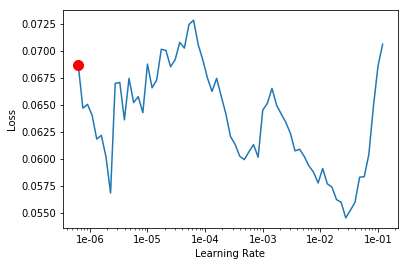

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(24, slice(3e-3), wd=5e-6)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.063797,0.166564,0.069600,0.930556,01:20
1,0.061465,0.139410,0.064000,0.936043,01:21
2,0.047806,0.113662,0.061600,0.938451,01:21
3,0.035331,0.097657,0.058400,0.941587,01:21
4,0.032698,0.090880,0.057600,0.942443,01:20
5,0.029216,0.087670,0.056800,0.943196,01:20
6,0.024367,0.084406,0.055200,0.944813,01:20
7,0.020505,0.088171,0.054400,0.945752,01:20
8,0.016836,0.093613,0.054400,0.945729,01:20
9,0.016104,0.096086,0.054400,0.945636,01:20


In [0]:
learn.save('SeResNxt50_FL_128t256_955163')

In [0]:
learn.load('SeResNxt50_FL_128t256_955163');

In [0]:
learn.unfreeze()
learn.clip_grad()

In [0]:
lr = [1e-3/200, 1e-3/20, 1e-3/10]
learn.fit_one_cycle(32, lr)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.004881,0.095006,0.045600,0.954393,01:47
1,0.003097,0.093848,0.044800,0.955180,01:51
2,0.004433,0.095179,0.048800,0.951225,01:51
3,0.004333,0.090997,0.048800,0.951150,01:51
4,0.005034,0.090667,0.044000,0.956029,01:51
5,0.006870,0.082818,0.040800,0.959146,01:51
6,0.004298,0.078488,0.042400,0.957726,01:51
7,0.005833,0.082735,0.038400,0.961643,01:51
8,0.005891,0.078535,0.040000,0.960144,01:51
9,0.006033,0.090153,0.038400,0.961598,01:51


In [0]:
learn.save('SeResNxt50_FL_s2_128t256_968019')

In [0]:
learn.load('SeResNxt50_FL_s2_128t256_968019');

In [0]:
preds, _ = learn.get_preds(DatasetType.Test)
pred_class = torch.argmax(preds, dim=1)
pred_class += 1
pred_numpy = pred_class.numpy()

In [0]:
write_submission(pred_numpy, 'Res50_FLmixup_aug_128t246_969718.csv')
#LB 0.972853019760771

## Size 299

In [0]:
SZ = 299
cutout_frac = 0.20
p_cutout = 0.75
cutout_sz = round(SZ*cutout_frac)
cutout_tfm = cutout(n_holes=(1,1), length=(cutout_sz, cutout_sz), p=p_cutout)

In [0]:
tfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1,
                      max_zoom=1.05, max_warp=0.,
                      xtra_tfms=[rand_crop(),
                                 symmetric_warp(magnitude=(-0.2, 0.2)), cutout_tfm])

In [0]:
data_299 = (src.transform(tfms, size=299, resize_method=ResizeMethod.SQUISH)
            .databunch(bs=48)
            .normalize(imagenet_stats))

In [0]:
learn = cnn_learner(data_299, se_resnext50_32x4d, pretrained=True, cut=-2,
                    split_on=lambda m: (m[0][3], m[1]), 
                    metrics=[error_rate, f_score])

In [0]:
learn.load('SeResNxt50_FL_s2_128t256_968019');
learn.freeze();
learn.clip_grad();
learn.mixup();

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [0]:
learn.fit_one_cycle(32, slice(1e-2))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.845434,0.126683,0.039200,0.960735,02:10
1,0.595398,0.166088,0.042400,0.957502,02:06
2,0.538603,0.165132,0.037600,0.962391,02:06
3,0.527696,0.156787,0.042400,0.957512,02:06
4,0.518446,0.153922,0.036800,0.963333,02:06
5,0.518304,0.160560,0.044800,0.955271,02:06
6,0.506956,0.135375,0.038400,0.961556,02:06
7,0.517231,0.141696,0.038400,0.961632,02:06
8,0.511918,0.142817,0.036800,0.963260,02:07
9,0.503191,0.145534,0.032800,0.967152,02:07


In [0]:
learn.save('SeResNext50_mixup_128t224t299_s1_970390')

In [0]:
learn.load('SeResNext50_mixup_128t224t299_s1_970390');

In [0]:
learn.unfreeze()
learn.clip_grad();
learn.mixup();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


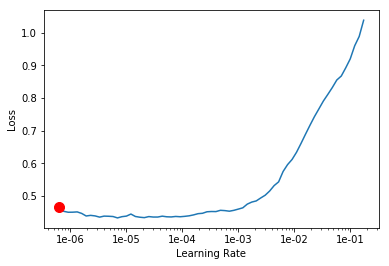

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
lr = [2e-5, 2e-4, 2e-3]
learn.fit_one_cycle(64, lr)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.458171,0.123312,0.030400,0.969585,03:00
1,0.442336,0.123213,0.032000,0.967988,02:50
2,0.446681,0.121806,0.028000,0.972012,02:50
3,0.445108,0.119733,0.031200,0.968784,02:50
4,0.449005,0.117211,0.028800,0.971261,02:50
5,0.444636,0.117236,0.026400,0.973619,02:50
6,0.437254,0.116157,0.028800,0.971179,02:50
7,0.442069,0.120598,0.037600,0.962389,02:51
8,0.438174,0.115766,0.028000,0.971990,02:51
9,0.441405,0.141391,0.047200,0.952582,02:51


In [0]:
learn.save('Se_ResNext50_mixup_aug_s2_124t256t299_976771')

In [0]:
preds, _ = learn.get_preds(DatasetType.Test)
pred_class = torch.argmax(preds, dim=1)
pred_class += 1
pred_numpy = pred_class.numpy()

In [0]:
write_submission(pred_numpy, 'Se_ResNet50_mix_aug_976771.csv')
#LB 0.980316980670933

In [0]:
predsTTA, _ = learn.TTA(ds_type=DatasetType.Test)
pred_class = torch.argmax(predsTTA, dim=1)
pred_class += 1
pred_numpy = pred_class.numpy()

In [0]:
write_submission(pred_numpy, 'Se_ResNet50_mix_aug_TTA_976771.csv')
#LB 0.979364735433383

In [0]:
class_name = ['Cargo', 'Military','Carrier' ,'Cruise','Tankers']

predTTA_df = pd.DataFrame(predsTTA.numpy(), columns=class_name)
preds_df = pd.DataFrame(preds.numpy(), columns=class_name)
preds_df.to_csv('Preds_SeResNeXt50_LB_980316.csv', index=False)
predTTA_df.to_csv('TTA_SeResNeXt50_LB_980316.csv', index=False)